# QCoDeS tutorial 
Basic overview of QCoDeS

## Typical QCodes workflow 
1. Start up an interactive python session (e.g. using jupyter) 
2. import desired modules 
3. instantiate required instruments 
4. experiment! 

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from pprint import pprint
import time
import numpy as np
import qcodes as qc

<IPython.core.display.Javascript object>

## Instantiates all the instruments needed for the demo

In [2]:
# spawn doesn't like function or class definitions in the interpreter
# session - had to move them to a file.
from toymodel import AModel, MockGates, MockSource, MockMeter, AverageGetter, AverageAndRaw

# now create this "experiment", note that all these are instruments 
model = AModel()
gates = MockGates('gates', model=model)
source = MockSource('source', model=model)
meter = MockMeter('meter', model=model)

# The station is a container for all instruments that makes it easy 
# to log meta-data
station = qc.Station(gates, source, meter)

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
c0, c1, c2, vsd = gates.chan0, gates.chan1, gates.chan2, source.amplitude

### The location provider can be set globally 

In [3]:
# dm = qc.data.manager.get_data_manager()
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

# Running an experiment 

### Defining the `Loop` and actions

Before you run a measurement loop you do two things:
1. You describe what parameter(s) to vary and how. This is the creation of a `Loop` object: `loop = Loop(sweep_values, ...)`
2. You describe what to do at each step in the loop. This is `loop.each(*actions)` which converts the `Loop` object into an `ActiveLoop` object. Actions can be:
  - measurements (any object with a `.get` method will be interpreted as a measurement)
  - `Task`: some callable (which can have arguments with it) to be executed each time through the loop. Does not generate data.
  - `Wait`: a specialized `Task` just to wait a certain time.
  - `BreakIf`: some condition that, if it returns truthy, breaks (this level of) the loop
  - Another `ActiveLoop` to nest inside the outer one.

For more details, see issue #232 docs: Write bigger picture

In [4]:
# Notice that one can use an explicit location and `overwrite=True` here so that
# running this notebook over and over won't result in extra files.
# If you leave these out, you get a new timestamped DataSet each time.

loop = qc.Loop(c0.sweep(0,20,0.1), delay=0.001).each(meter.amplitude)
data = loop.get_data_set(name='testsweep')
plot = qc.QtPlot()
plot.add(data.meter_amplitude)
_ = loop.with_bg_task(plot.update, 0.0005).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-10-10/#014_testsweep_15-46-51'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | gates_chan0_set | chan0        | (201,)
   Measured | meter_amplitude | amplitude    | (201,)
started at 2016-10-10 15:47:11


## Output of the loop
Notice the **"DataSet"**.  
A loop returns a dataset.  
The representation of the dataset shows what arrays it contains and where it is saved.   
The dataset initially starts out empty (filled with NAN's) and get's filled while the Loop get's executed. 

Once the measurement is done, take a look at the file in finder/explorer (the dataset.location should give you the relative path). 
Note also the snapshot that captures the settings of all instruments at the start of the Loop. 
This metadata is also accesible from the dataset and captures a snapshot of each instrument listed in the station. 

In [5]:
meter.snapshot()

{'__class__': 'toymodel.MockMeter',
 'functions': {},
 'name': 'meter',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.StandardParameter',
   'instrument': 'toymodel.MockMeter',
   'instrument_name': 'meter',
   'label': 'IDN',
   'name': 'IDN',
   'ts': '2016-09-29 15:13:21',
   'units': '',
   'value': {'firmware': None,
    'model': 'MockMeter',
    'serial': 'meter',
    'vendor': None}},
  'amplitude': {'__class__': 'qcodes.instrument.parameter.StandardParameter',
   'instrument': 'toymodel.MockMeter',
   'instrument_name': 'meter',
   'label': 'Current (nA)',
   'name': 'amplitude',
   'ts': '2016-09-29 15:13:40',
   'units': '',
   'value': 0.117}}}

## Plotting the loop  II

QCodes supports both matplotlib inline plotting and pyqtgraph for plotting. 
For a comparison see http://pyqtgraph.org/ (actually not that biased)

The same API works for plotting a measured dataset or an old  dataset.

`DataSet` objects are not intended to be instantiated directly, but
rather through the helper functions:
- `load_data` for existing data sets, including the data currently
  being acquired.
- `new_data` to make an empty data set to be populated with new
  measurements or simulation data. `new_data` is called internally by
  `Loop.run()` so is also generally not needed directly.

<IPython.core.display.Javascript object>


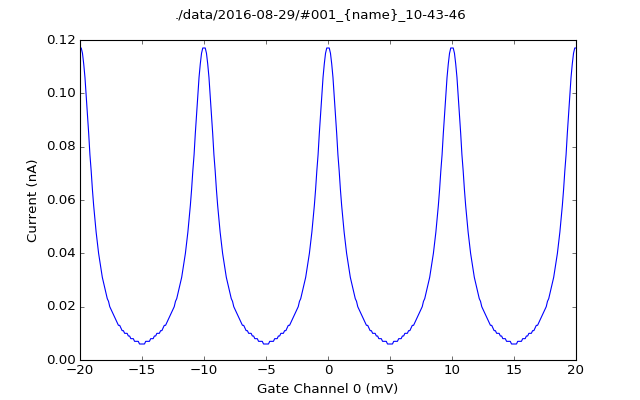

In [6]:
loaded_data = qc.load_data("./data/2016-08-29/#001_{name}_10-43-46")
plot = qc.MatPlot(loaded_data.meter_amplitude)

## Example: multiple 2D measurements with live plotting

In [5]:
loop = qc.Loop(c1[-15:15:1], 0.01).loop(c0[-15:12:.5], 0.001).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    qc.Task(c2.set, 1), # action 1 -> c2.set(1)
    qc.Wait(0.001),
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    qc.Task(c2.set, 0)
    )
data = loop.get_data_set(name='2D_test')

### Plot with matplotlib 

<IPython.core.display.Javascript object>


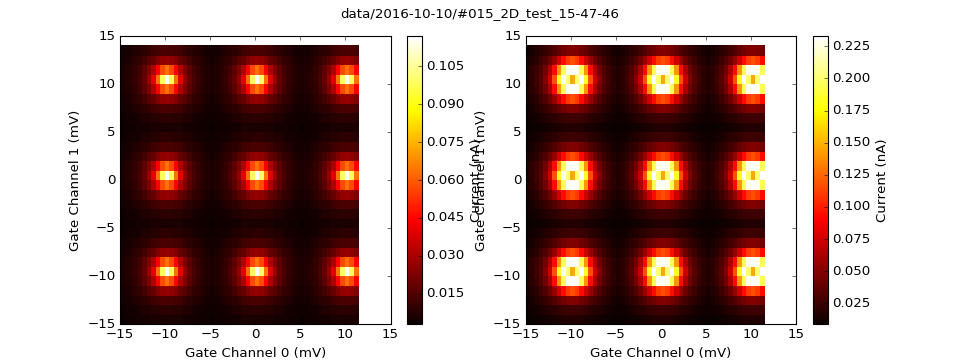

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-10-10/#015_2D_test_15-47-46'
   <Type>   | <array_id>        | <array.name> | <array.shape>
   Setpoint | gates_chan1_set   | chan1        | (30,)
   Setpoint | gates_chan0_set   | chan0        | (30, 54)
   Measured | meter_amplitude_0 | amplitude    | (30, 54)
   Measured | meter_amplitude_3 | amplitude    | (30, 54)
started at 2016-10-10 15:48:01


In [6]:
plot = qc.MatPlot(data.meter_amplitude_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1, 2))
plot.add(data.meter_amplitude_3, cmap=plt.cm.hot, subplot=2)
data2 = loop.with_bg_task(plot.update, 0.0005).run()

### The equivalent in QtPlot

In [8]:
loop = qc.Loop(c1[-15:15:1], 0.01).loop(c0[-15:12:.5], 0.001).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    qc.Task(c2.set, 1), # action 1 -> c2.set(1)
    qc.Wait(0.001),
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    qc.Task(c2.set, 0)
    )
data = loop.get_data_set(name='2D_test')

plotQ = qc.QtPlot()
plotQ.add(data.meter_amplitude_0, figsize=(1200, 500))
plotQ.add(data.meter_amplitude_3, subplot=2)
data2 = loop.with_bg_task(plotQ.update, 0.0005).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-10-10/#016_2D_test_15-48-17'
   <Type>   | <array_id>        | <array.name> | <array.shape>
   Setpoint | gates_chan1_set   | chan1        | (30,)
   Setpoint | gates_chan0_set   | chan0        | (30, 54)
   Measured | meter_amplitude_0 | amplitude    | (30, 54)
   Measured | meter_amplitude_3 | amplitude    | (30, 54)
started at 2016-10-10 15:48:40


### Example same outer loop, different inner loop 

In [10]:
loop3 = qc.Loop(c1[-15:15:1], 0.1).each(
    qc.Task(c0.set, -10),
    qc.Task(c2.set, 0),
    # a 1D measurement
    meter.amplitude,
    # a 2D sweep, .each is actually unnecessary because this is the default measurement
    qc.Loop(c0[-15:15:1], 0.001).each(meter.amplitude),
    qc.Task(c0.set, -10),
    # a 2D sweep with the same outer but different inner loop
    qc.Loop(c2[-10:10:0.2], 0.001).each(meter.amplitude),
    AverageGetter(meter.amplitude, c2[-10:10:0.2], 0.001)
)
data = loop3.get_data_set() 

### several plots updating simultaneously (Currently broken on matplotlib)

In [11]:
plotQ = qc.QtPlot()
plotQ.add(data.meter_amplitude_3_0)
plotQ.add(data.meter_amplitude_5_0, cmap='viridis', subplot=2)
plotQ.add(data.meter_avg_amplitude, subplot=3)
data = loop3.with_bg_task(plotQ.update, 0.0005).run()

/home/unga/Hack/qdev/qcodes/plots/pyqtgraph.py:292: UserWarning: nonuniform nested setpoint array passed to pyqtgraph. ignoring, using default scaling.
  'nonuniform nested setpoint array passed to '


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-09-29/#031_{name}_15-14-23'
   <Type>   | <array_id>          | <array.name>  | <array.shape>
   Setpoint | gates_chan1_set     | chan1         | (30,)
   Measured | meter_amplitude_2   | amplitude     | (30,)
   Setpoint | gates_chan0_set     | chan0         | (30, 30)
   Measured | meter_amplitude_3_0 | amplitude     | (30, 30)
   Setpoint | gates_chan2_set     | chan2         | (30, 100)
   Measured | meter_amplitude_5_0 | amplitude     | (30, 100)
   Measured | meter_avg_amplitude | avg_amplitude | (30,)
started at 2016-09-29 15:15:07


### Example 2D scan and average

 An example of a parameter that returns several values of different dimension
 This produces the last two arrays from data3, but only takes the data once.

In [9]:
loop4 = qc.Loop(c1[-15:15:1], 0.01).each(
    AverageAndRaw(meter.amplitude, c2[-10:10:0.2], 0.001)
)
data4 = loop4.get_data_set(name='TwoD_average_test')
plotQ = qc.QtPlot()
plotQ.add(data4.meter_amplitude, figsize=(1200, 500), cmap='viridis')
plotQ.add(data4.meter_avg_amplitude, subplot=2)
data4 = loop4.with_bg_task(plotQ.update, 0.005).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-10-10/#017_TwoD_average_test_15-49-11'
   <Type>   | <array_id>          | <array.name>  | <array.shape>
   Setpoint | gates_chan1_set     | chan1         | (30,)
   Measured | chan2               | chan2         | (30, 100)
   Measured | meter_amplitude     | amplitude     | (30, 100)
   Measured | meter_avg_amplitude | avg_amplitude | (30,)
started at 2016-10-10 15:49:28
